In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [3]:
df["PrevClose"] = df["close"].shift(1)

In [4]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [5]:
df["Return"] = (df["close"] - df["PrevClose"]) / df["PrevClose"]

In [6]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


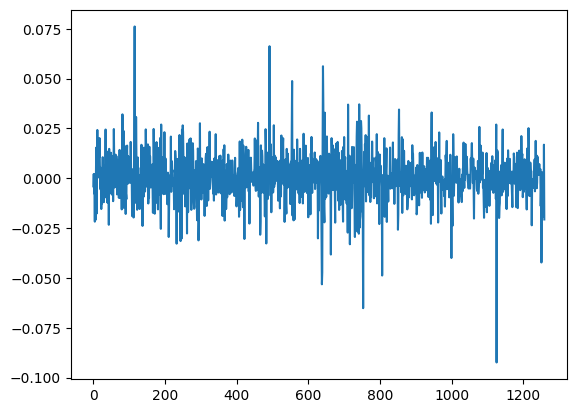

In [7]:
plt.plot(df["Return"])
plt.show()

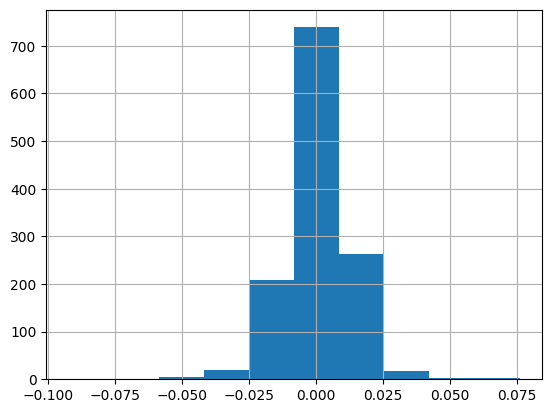

In [8]:
df["Return"].hist()
plt.show()

In [9]:
series = df["Return"].values[1:].reshape(-1, 1)

scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()
series

array([-0.43811722,  0.08061497, -0.73536414, ..., -1.71332483,
        1.30572463, -1.82299002])

In [10]:
# Build the dataset
T = 20
D = 1
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t + T]
    X.append(x)
    y = series[t + T]
    Y.append(y)
    
X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1238, 20, 1) Y.shape (1238, 1)


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [12]:
class SimpleRNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(SimpleRNN, self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        
        self.rnn = nn.LSTM(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            # nonlinearity='relu',
            batch_first=True
        )
        self.fc = nn.Linear(self.M, self.K)
        
    def forward(self, X):
        # initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

        # get RNN unit output
        # out is of size (N, T, M)
        out, _ = self.rnn(X, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [13]:
model = SimpleRNN(n_inputs=1, n_hidden=5, n_rnnlayers=1, n_outputs=1)
model.to(device)

SimpleRNN(
  (rnn): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
criteria = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [15]:
def full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=200):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for it in range(epochs):
        optimizer.zero_grad()
        
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        loss.backward()
        optimizer.step()
        
        train_losses[it] = loss.item()
        
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[it] = test_loss.item()
        
        if (it + 1) % 5 == 0:
            print(f'Epoch {it + 1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
    
    return train_losses, test_losses

In [16]:
x_train = torch.from_numpy(X[:-N//2].astype(np.float32)).to(device)
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32)).to(device)
x_test = torch.from_numpy(X[-N//2:].astype(np.float32)).to(device)
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32)).to(device)

In [17]:
x_train = torch.from_numpy(X[:-N//2].astype(np.float32)).to(device)
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32)).to(device)
x_test = torch.from_numpy(X[-N//2:].astype(np.float32)).to(device)
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32)).to(device)

Epoch 5/200, Train Loss: 1.0681, Test Loss: 1.0745
Epoch 10/200, Train Loss: 1.0528, Test Loss: 1.0768
Epoch 15/200, Train Loss: 1.0585, Test Loss: 1.0834
Epoch 20/200, Train Loss: 1.0519, Test Loss: 1.0687
Epoch 25/200, Train Loss: 1.0503, Test Loss: 1.0712
Epoch 30/200, Train Loss: 1.0453, Test Loss: 1.0801
Epoch 35/200, Train Loss: 1.0381, Test Loss: 1.0809
Epoch 40/200, Train Loss: 1.0283, Test Loss: 1.1034
Epoch 45/200, Train Loss: 1.0191, Test Loss: 1.1206
Epoch 50/200, Train Loss: 1.0110, Test Loss: 1.1200
Epoch 55/200, Train Loss: 1.0011, Test Loss: 1.1243
Epoch 60/200, Train Loss: 0.9889, Test Loss: 1.1664
Epoch 65/200, Train Loss: 0.9783, Test Loss: 1.1759
Epoch 70/200, Train Loss: 0.9703, Test Loss: 1.2183
Epoch 75/200, Train Loss: 0.9573, Test Loss: 1.2006
Epoch 80/200, Train Loss: 0.9440, Test Loss: 1.3007
Epoch 85/200, Train Loss: 0.9547, Test Loss: 1.1826
Epoch 90/200, Train Loss: 0.9508, Test Loss: 1.2260


Epoch 95/200, Train Loss: 0.9491, Test Loss: 1.1740
Epoch 100/200, Train Loss: 0.9238, Test Loss: 1.2232
Epoch 105/200, Train Loss: 0.9010, Test Loss: 1.2308
Epoch 110/200, Train Loss: 0.8778, Test Loss: 1.2658
Epoch 115/200, Train Loss: 0.8831, Test Loss: 1.1966
Epoch 120/200, Train Loss: 0.8995, Test Loss: 1.1826
Epoch 125/200, Train Loss: 0.8621, Test Loss: 1.2585
Epoch 130/200, Train Loss: 0.8273, Test Loss: 1.3464
Epoch 135/200, Train Loss: 0.8490, Test Loss: 1.2647
Epoch 140/200, Train Loss: 0.8463, Test Loss: 1.2745
Epoch 145/200, Train Loss: 0.8306, Test Loss: 1.3169
Epoch 150/200, Train Loss: 0.9399, Test Loss: 1.2966
Epoch 155/200, Train Loss: 1.0181, Test Loss: 1.1637
Epoch 160/200, Train Loss: 0.9967, Test Loss: 1.1082
Epoch 165/200, Train Loss: 0.9935, Test Loss: 1.1126
Epoch 170/200, Train Loss: 0.9819, Test Loss: 1.1454
Epoch 175/200, Train Loss: 0.9763, Test Loss: 1.1759
Epoch 180/200, Train Loss: 0.9696, Test Loss: 1.1721
Epoch 185/200, Train Loss: 0.9626, Test Loss: 1

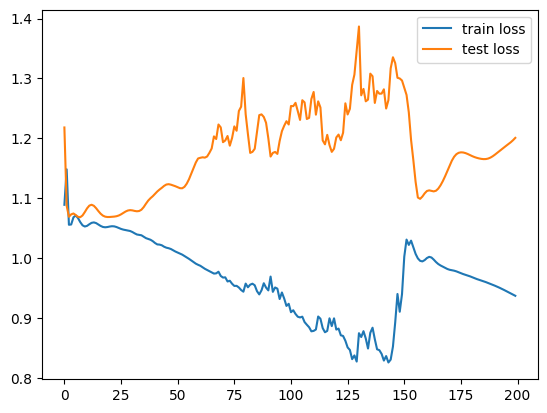

In [18]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [19]:
# One-step forecast using true targets
validation_target = Y
validation_predictions = []

# index of first validation input
i = 0

X_on_device = torch.from_numpy(X.astype(np.float32)).to(device)

while len(validation_predictions) < len(validation_target):
    input_ = X_on_device[i].reshape(1, T, 1)
    p = model(input_)[0, 0].item()
    
    i += 1
    
    # update the predictions list
    validation_predictions.append(p)

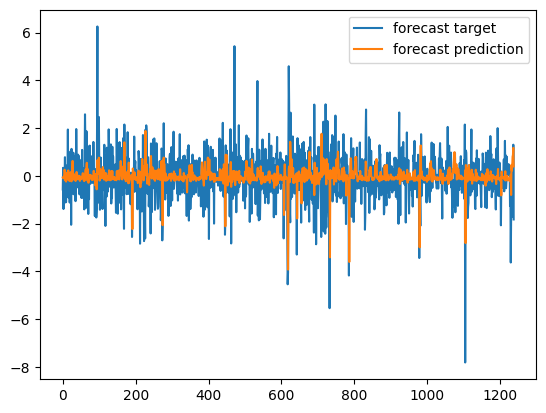

In [20]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()
plt.show()

In [21]:
# multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = x_test[0].view(T)

while len(validation_predictions) < len(validation_target):
    input_ = last_x.reshape(1, T, 1)
    p = model(input_)
    
    # update the predictions list
    validation_predictions.append(p[0, 0].item())
    
    # make the new input
    last_x = torch.cat((last_x[1:], p[0]))

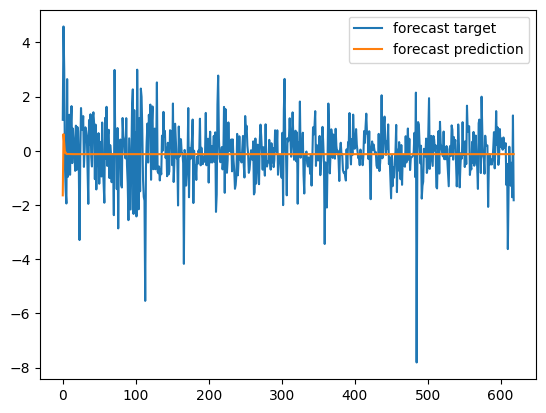

In [22]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()
plt.show()